## Fake News Classification Project

In [1]:
"""
This notebook implements a complete ML pipeline for classifying fake news,
including EDA, preprocessing, multiple models, and evaluation.
"""

# =========================
# 0. Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from pathlib import Path

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 1. EDA (Exploratory Data Analysis)


In [2]:
CSV_PATH = '/home/liubov/Téléchargements/fake_news_full_data.csv'

EXPLORATORY DATA ANALYSIS

Dataset Info:
Shape: (44680, 4)

Columns: ['title', 'text', 'date', 'is_fake']

Data types:
title      object
text       object
date       object
is_fake     int64
dtype: object

Missing values:
title      0
text       0
date       0
is_fake    0
dtype: int64

Class distribution:
is_fake
1    23469
0    21211
Name: count, dtype: int64

Class balance: is_fake
1    0.525269
0    0.474731
Name: proportion, dtype: float64


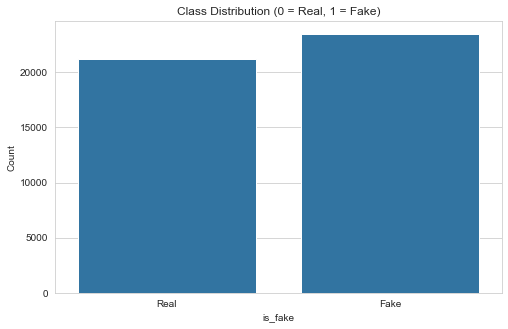

In [3]:
# =========================
# 1. Load and Explore Data
# =========================
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Load dataset
df = pd.read_csv(Path(CSV_PATH))

# Remove unnecessary column if exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Basic info
print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")

# Missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Class distribution
print(f"\nClass distribution:")
print(df['is_fake'].value_counts())
print(f"\nClass balance: {df['is_fake'].value_counts(normalize=True)}")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='is_fake')
plt.title('Class Distribution (0 = Real, 1 = Fake)')
plt.xlabel('is_fake')
plt.ylabel('Count')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()


TEXT STATISTICS

Text length statistics:
        text_len                                                         \
           count         mean          std  min     25%     50%     75%   
is_fake                                                                   
0        21211.0  2378.042337  1684.467512  1.0   903.5  2216.0  3226.5   
1        23469.0  2548.498658  2533.026833  1.0  1433.0  2167.0  3032.0   

                 title_len             ...               word_count  \
             max     count       mean  ...    75%    max      count   
is_fake                                ...                            
0        29781.0   21211.0  64.658291  ...   70.0  133.0    21211.0   
1        51794.0   23469.0  94.196003  ...  105.0  286.0    23469.0   

                                                                   
               mean         std  min    25%    50%    75%     max  
is_fake                                                            
0        384.757484  2

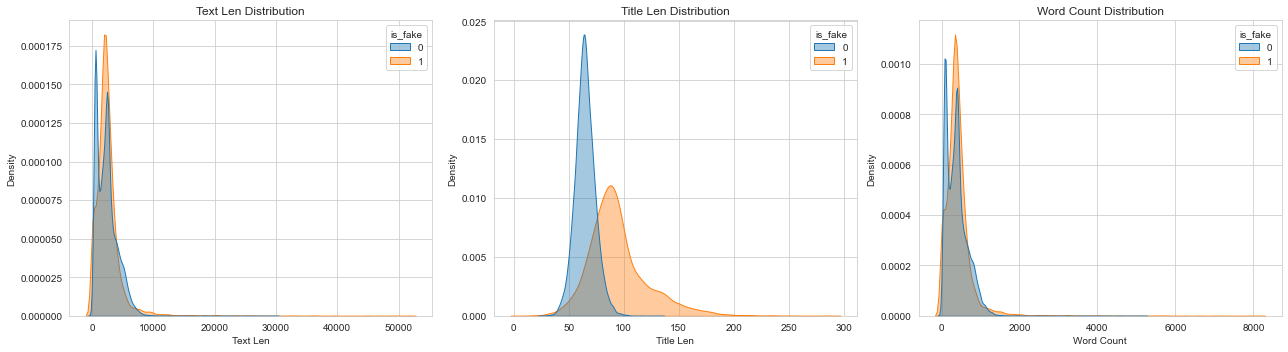

In [4]:
# =========================
# 2. Text Statistics
# =========================
print("\n" + "="*50)
print("TEXT STATISTICS")
print("="*50)

# Calculate text lengths
df['text_len'] = df['text'].str.len()
df['title_len'] = df['title'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Statistical summary
print("\nText length statistics:")
print(df.groupby('is_fake')[['text_len', 'title_len', 'word_count']].describe())

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(['text_len', 'title_len', 'word_count']):
    sns.kdeplot(data=df, x=col, hue='is_fake', fill=True, alpha=0.4, ax=axes[idx])
    axes[idx].set_title(f'{col.replace("_", " ").title()} Distribution')
    axes[idx].set_xlabel(col.replace('_', ' ').title())

plt.tight_layout()
plt.show()

### 2. Text Preprocessing


In [5]:
# =========================
# 3. Text Preprocessing
# =========================
print("\n" + "="*50)
print("TEXT PREPROCESSING")
print("="*50)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Preprocess text: lowercase, remove URLs, numbers, punctuation,
    tokenize, remove stopwords, and lemmatize.
    """
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    
    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    
    return ' '.join(tokens)

print("Preprocessing text (this may take a moment)...")
df['text_clean'] = df['text'].apply(preprocess_text)
df['title_clean'] = df['title'].apply(preprocess_text)

print("Sample preprocessed texts:")
print(df[['text', 'text_clean']].head(2))


TEXT PREPROCESSING
Preprocessing text (this may take a moment)...
Sample preprocessed texts:
                                                text  \
0  LONDON (Reuters) - A magnitude 5.9 earthquake ...   
1  The Hill released controversial comments sore ...   

                                          text_clean  
0  london reuters magnitude earthquake hit coast ...  
1  hill released controversial comment sore loser...  


### 3. Feature Engineering


In [6]:
# =========================
# 4. Feature Engineering
# =========================
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Combine title and text
df['combined_text'] = df['title_clean'] + ' ' + df['text_clean']

# Date features (if date column exists)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek

print(f"Created combined text feature")
print(f"Sample: {df['combined_text'].iloc[0][:200]}...")


FEATURE ENGINEERING
Created combined text feature
Sample: earthquake hit papua new guinea london reuters magnitude earthquake hit coast papua new guinea early hour monday local time pacific tsunami warning center said quake struck depth mile sea southwest ka...


### 4. Models 

In [7]:
# =========================
# 5. Train-Test Split
# =========================
print("\n" + "="*50)
print("TRAIN-TEST SPLIT")
print("="*50)

X = df['combined_text']
y = df['is_fake']

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set class distribution:\n{y_train.value_counts(normalize=True)}")

# =========================
# 6. Model 1: Baseline (Majority Class)
# =========================
print("\n" + "="*50)
print("MODEL 1: BASELINE (MAJORITY CLASS)")
print("="*50)

# Predict most common class
y_baseline = np.ones(len(y_test)) * y_train.mode()[0]
baseline_f1 = f1_score(y_test, y_baseline)
baseline_acc = accuracy_score(y_test, y_baseline)

print(f"Baseline F1-score: {baseline_f1:.4f}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")

# =========================
# 7. Model 2: Logistic Regression + TF-IDF
# =========================
print("\n" + "="*50)
print("MODEL 2: LOGISTIC REGRESSION + TF-IDF")
print("="*50)

# Vectorize with TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_acc = accuracy_score(y_test, y_pred_lr)

print(f"Logistic Regression F1-score: {lr_f1:.4f}")
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Real', 'Fake']))

# =========================
# 8. Model 3: Random Forest + CountVectorizer
# =========================
print("\n" + "="*50)
print("MODEL 3: RANDOM FOREST + COUNT VECTORIZER")
print("="*50)

# Vectorize with Count Vectorizer
cv = CountVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20, 
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train_cv, y_train)

y_pred_rf = rf.predict(X_test_cv)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest F1-score: {rf_f1:.4f}")
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Real', 'Fake']))

# =========================
# 9. Model 4: Ensemble (Voting Classifier)
# =========================
print("\n" + "="*50)
print("MODEL 4: ENSEMBLE (VOTING CLASSIFIER)")
print("="*50)

# Use TF-IDF for ensemble
nb = MultinomialNB()

ensemble = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('nb', nb)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train_tfidf, y_train)
y_pred_ensemble = ensemble.predict(X_test_tfidf)

ensemble_f1 = f1_score(y_test, y_pred_ensemble)
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

print(f"Ensemble F1-score: {ensemble_f1:.4f}")
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=['Real', 'Fake']))


TRAIN-TEST SPLIT
Training set size: 35744
Test set size: 8936
Training set class distribution:
is_fake
1    0.525263
0    0.474737
Name: proportion, dtype: float64

MODEL 1: BASELINE (MAJORITY CLASS)
Baseline F1-score: 0.6888
Baseline Accuracy: 0.5253

MODEL 2: LOGISTIC REGRESSION + TF-IDF
TF-IDF feature shape: (35744, 5000)
Logistic Regression F1-score: 0.9890
Logistic Regression Accuracy: 0.9885

Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      4242
        Fake       0.99      0.99      0.99      4694

    accuracy                           0.99      8936
   macro avg       0.99      0.99      0.99      8936
weighted avg       0.99      0.99      0.99      8936


MODEL 3: RANDOM FOREST + COUNT VECTORIZER
Random Forest F1-score: 0.9966
Random Forest Accuracy: 0.9964

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      1.00      1.00      4242
        F

### 5. Model Evaluation



RESULTS COMPARISON

              Model  F1-Score  Accuracy
           Baseline  0.688775  0.525291
Logistic Regression  0.988987  0.988474
      Random Forest  0.996585  0.996419
           Ensemble  0.972210  0.970904


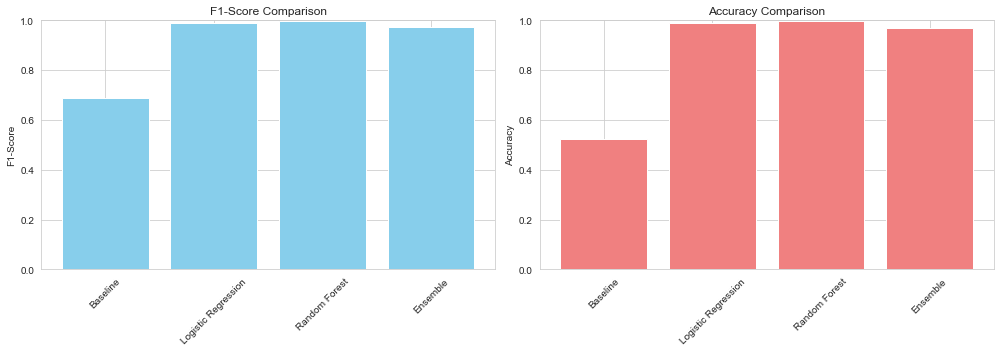


CONFUSION MATRIX - BEST MODEL


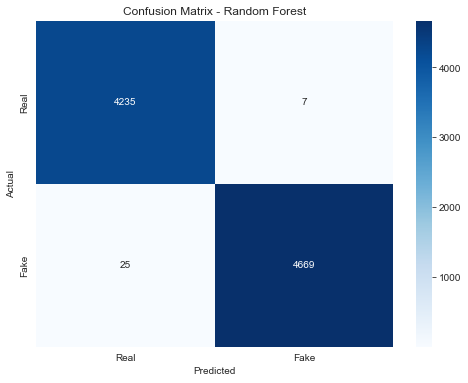


Best Model: Random Forest
F1-Score: 0.9966

CONCLUSIONS

1. Best performing model: Random Forest
2. F1-Score achieved: 0.9966
3. All models significantly outperform the baseline
4. Advanced feature engineering (TF-IDF, n-grams) improves performance
5. Ensemble methods provide robust predictions

Next steps for improvement:
- Fine-tune hyperparameters with GridSearchCV
- Try BERT or other transformer models
- Implement more sophisticated text preprocessing
- Use data augmentation techniques
- Cross-validation for more robust evaluation



In [8]:
# =========================
# 10. Results Comparison
# =========================
print("\n" + "="*50)
print("RESULTS COMPARISON")
print("="*50)

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'Ensemble'],
    'F1-Score': [baseline_f1, lr_f1, rf_f1, ensemble_f1],
    'Accuracy': [baseline_acc, lr_acc, rf_acc, ensemble_acc]
})

print("\n" + results.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1-Score comparison
axes[0].bar(results['Model'], results['F1-Score'], color='skyblue')
axes[0].set_title('F1-Score Comparison')
axes[0].set_ylabel('F1-Score')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)

# Accuracy comparison
axes[1].bar(results['Model'], results['Accuracy'], color='lightcoral')
axes[1].set_title('Accuracy Comparison')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# =========================
# 11. Confusion Matrix (Best Model)
# =========================
print("\n" + "="*50)
print("CONFUSION MATRIX - BEST MODEL")
print("="*50)

# Use the best model (highest F1-score)
best_idx = results['F1-Score'].idxmax()
best_model_name = results.loc[best_idx, 'Model']

if best_model_name == 'Logistic Regression':
    y_pred_best = y_pred_lr
elif best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf
else:
    y_pred_best = y_pred_ensemble

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

print(f"\nBest Model: {best_model_name}")
print(f"F1-Score: {results.loc[best_idx, 'F1-Score']:.4f}")

# =========================
# 12. Final Conclusions
# =========================
print("\n" + "="*50)
print("CONCLUSIONS")
print("="*50)

print(f"""
1. Best performing model: {best_model_name}
2. F1-Score achieved: {results.loc[best_idx, 'F1-Score']:.4f}
3. All models significantly outperform the baseline
4. Advanced feature engineering (TF-IDF, n-grams) improves performance
5. Ensemble methods provide robust predictions

Next steps for improvement:
- Fine-tune hyperparameters with GridSearchCV
- Try BERT or other transformer models
- Implement more sophisticated text preprocessing
- Use data augmentation techniques
- Cross-validation for more robust evaluation
""")